# Overview of Audio, Spectrogram, & AudioMoth modules

In this example, we'll use OpenSoundscape for exploratory data analysis of audio data. We'll load, visualize, edit, and make basic measurements of audio files. 

Here, we'll use two AudioMoth recordings as examples: one of several Winter Wren songs and another of a Northern Parula call. Both recordings were collected by the Kitzes Lab in one of our field deployments.

In [6]:
# Import the Audio and Spectrogram classes from opensoundscape
from opensoundscape import Audio, Spectrogram

# import plotting libraries and change settings
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

# ignore a specific deprecation warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

#### Load an audio file containing a winter wren song


In [12]:
resource_path = './resources/01/'
audio_path = resource_path + 'winterWren.WAV'

In [13]:
# Here, we load in the audio from a given file location.
audio = Audio.from_file(audio_path)

# Print our sound's duration and sample rate from the Audio object.
print(f"Audio is {audio.duration} seconds long and has a sample rate of {audio.sample_rate} Hz.")

Audio is 60.0 seconds long and has a sample rate of 32000 Hz.


### View metadata
This audio file was recorded by an AudioMoth. OpenSoundscape automatically parses metadata from AudioMoth recordings, and stores them in the audio object's `.metadata` dictionary. This includes information such as temperature, device ID, start time of recording, and gain setting as separate fields.

Let's look at a few of the metadata values:

In [4]:
print(f"recording start time: {audio.metadata['recording_start_time']}")
print(f"device ID: {audio.metadata['device_id']}")
print(f"temperature at start of recording: {audio.metadata['temperature_C']} C")
print(f"battery voltage: {audio.metadata['battery_state']} V")

recording start time: 2021-06-24 10:32:00+00:00
device ID: AudioMoth 240435085A34AA85
temperature at start of recording: 13.9 C
battery voltage: 4.0 V


## Visualize the audio file with a spectrogram

Now, let's visualize our sound as a spectrogram using OpenSoundscape's Spectrogram module. A spectrogram is a 2-dimensional representation of sound with time on the x-axis and frequency on the y-axis. 

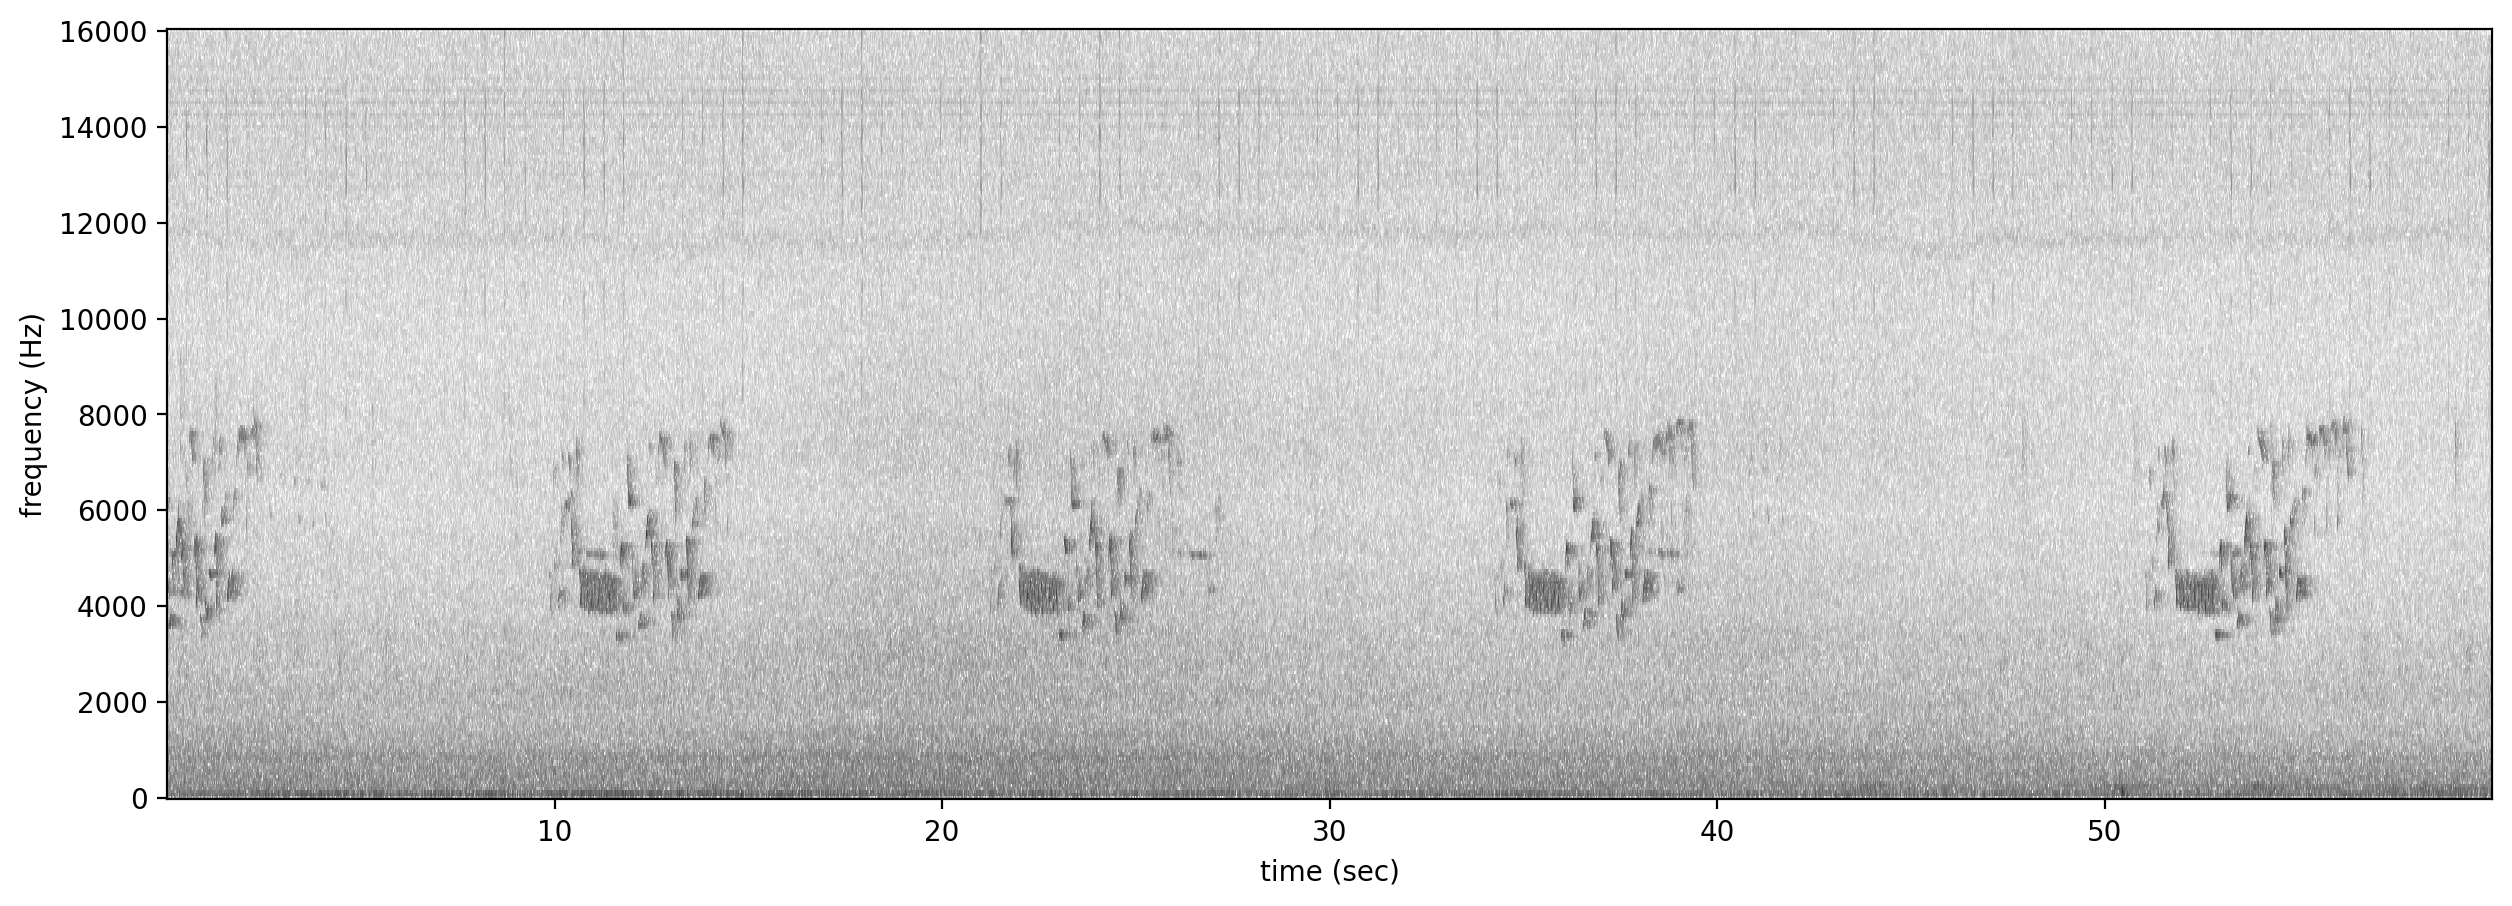

In [7]:
# Create spectrogram object from our previously loaded audio object and view it. 
spec = Spectrogram.from_audio(audio)

# Show the spectrogram as an image
spec.plot()

### "zoom in" on the spectrogram with trim and bandpass

Though we can see the whole soundscape visualized above, this spectrogram doesn't tell us much about the Winter Wren call that we want to investigate. Let's trim and bandpass the spectrogram to the region of the first song: 10-15 seconds, and 3000-8000 Hz. 

In [8]:
# Get the desired segment of audio.
trimmed_audio = audio.trim(50, 57)

# Print new duration and sample rate.
print(f"trimmed_audio is {trimmed_audio.duration} seconds long.")

trimmed_audio is 7.0 seconds long.


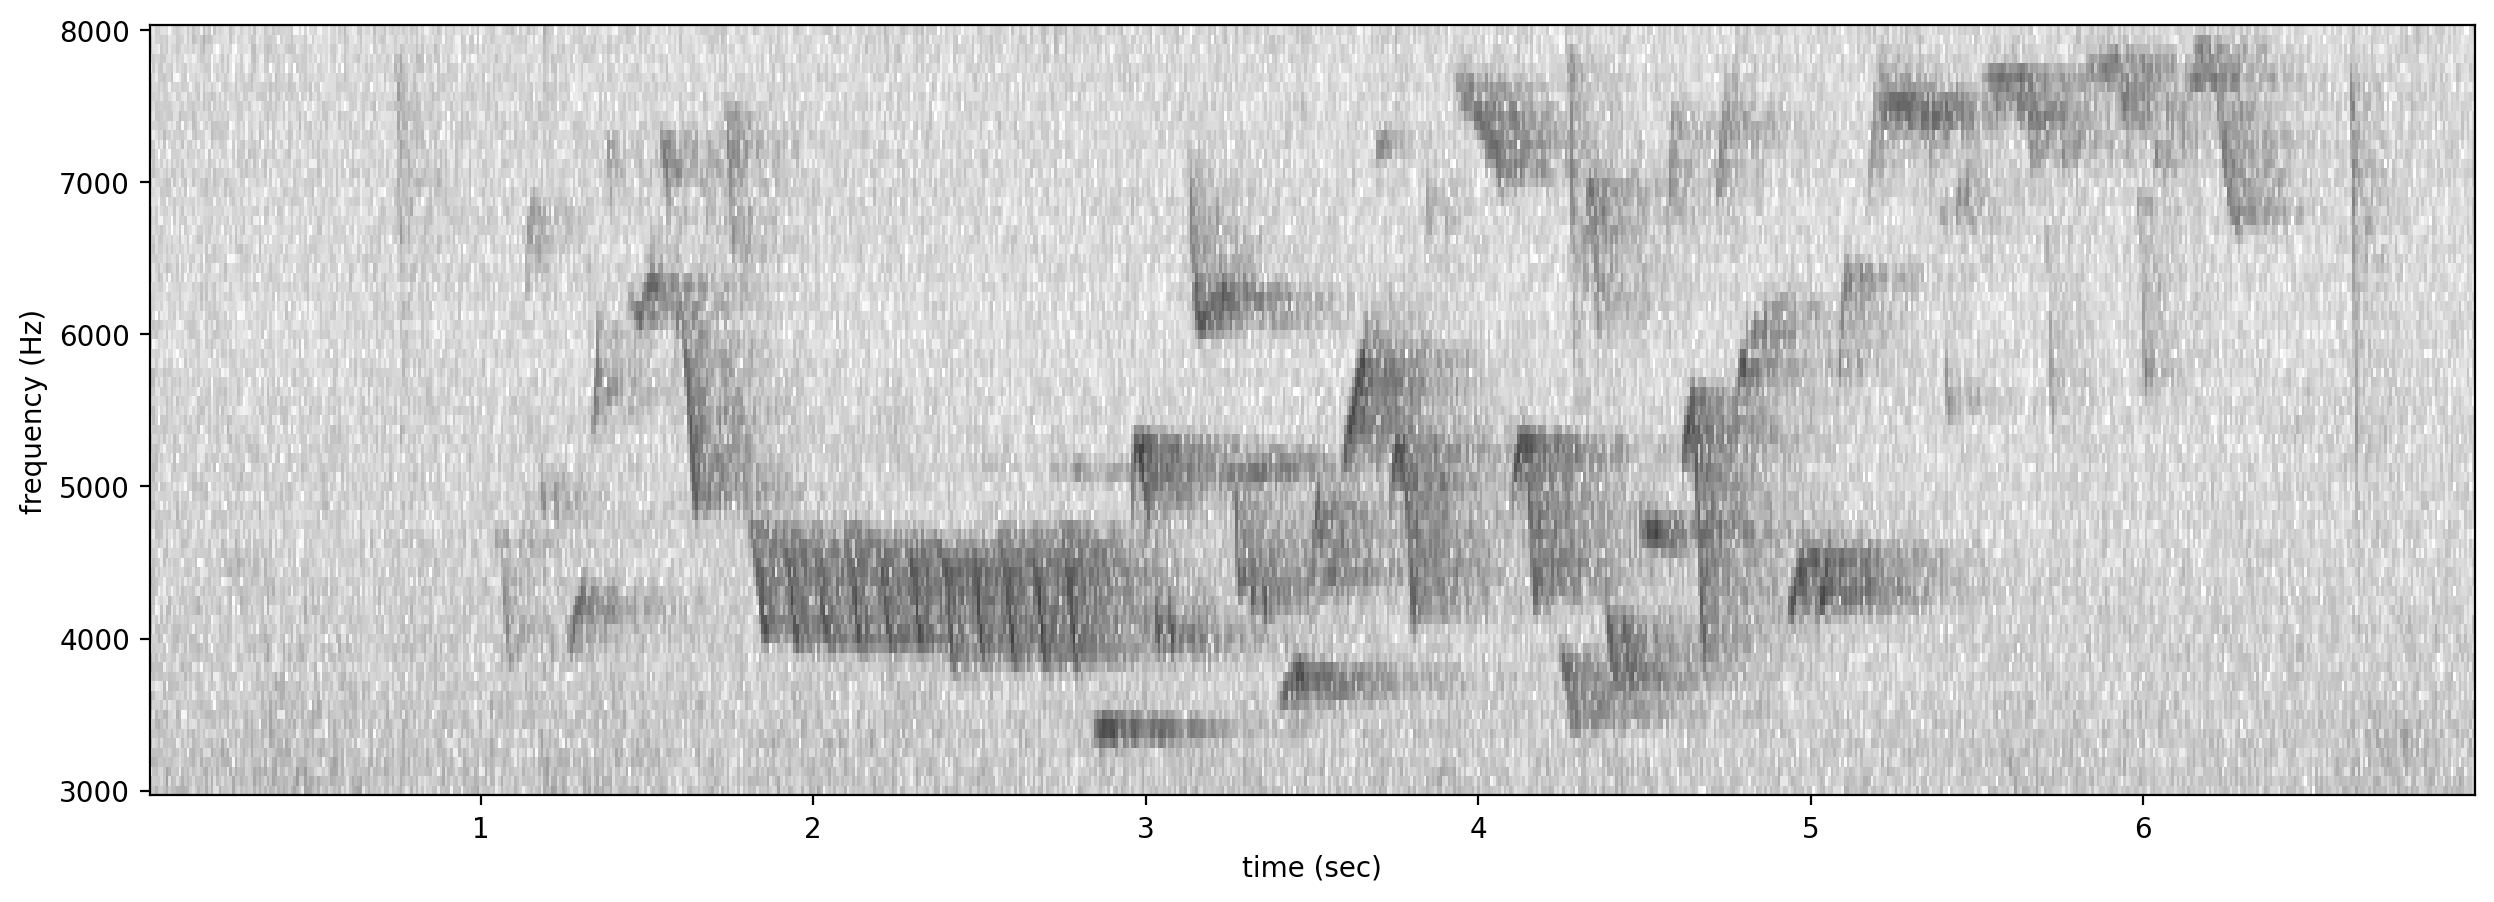

In [9]:
# Create spectrogram object from our previously loaded, trimmed audio object and view it. 
spec = Spectrogram.from_audio(trimmed_audio)

# bandpass the spectrogram to 3000-8000 Hz
spec = spec.bandpass(3000,8000)

# show spectrogram as image
spec.plot()

### adjust spectrogram parameters for frequency/time resolution 
The syllables of the winter wren are looking fuzzy here. To improve the frequency resolution of the spectrogram, let's try modifying the spectrogram generation parameters. We'll change the window size from the default of 512 to 1024 (increases frequency resolution at the cost of time resolution), and increase window overlap fraction to 0.8 to improve temporal resolution. 

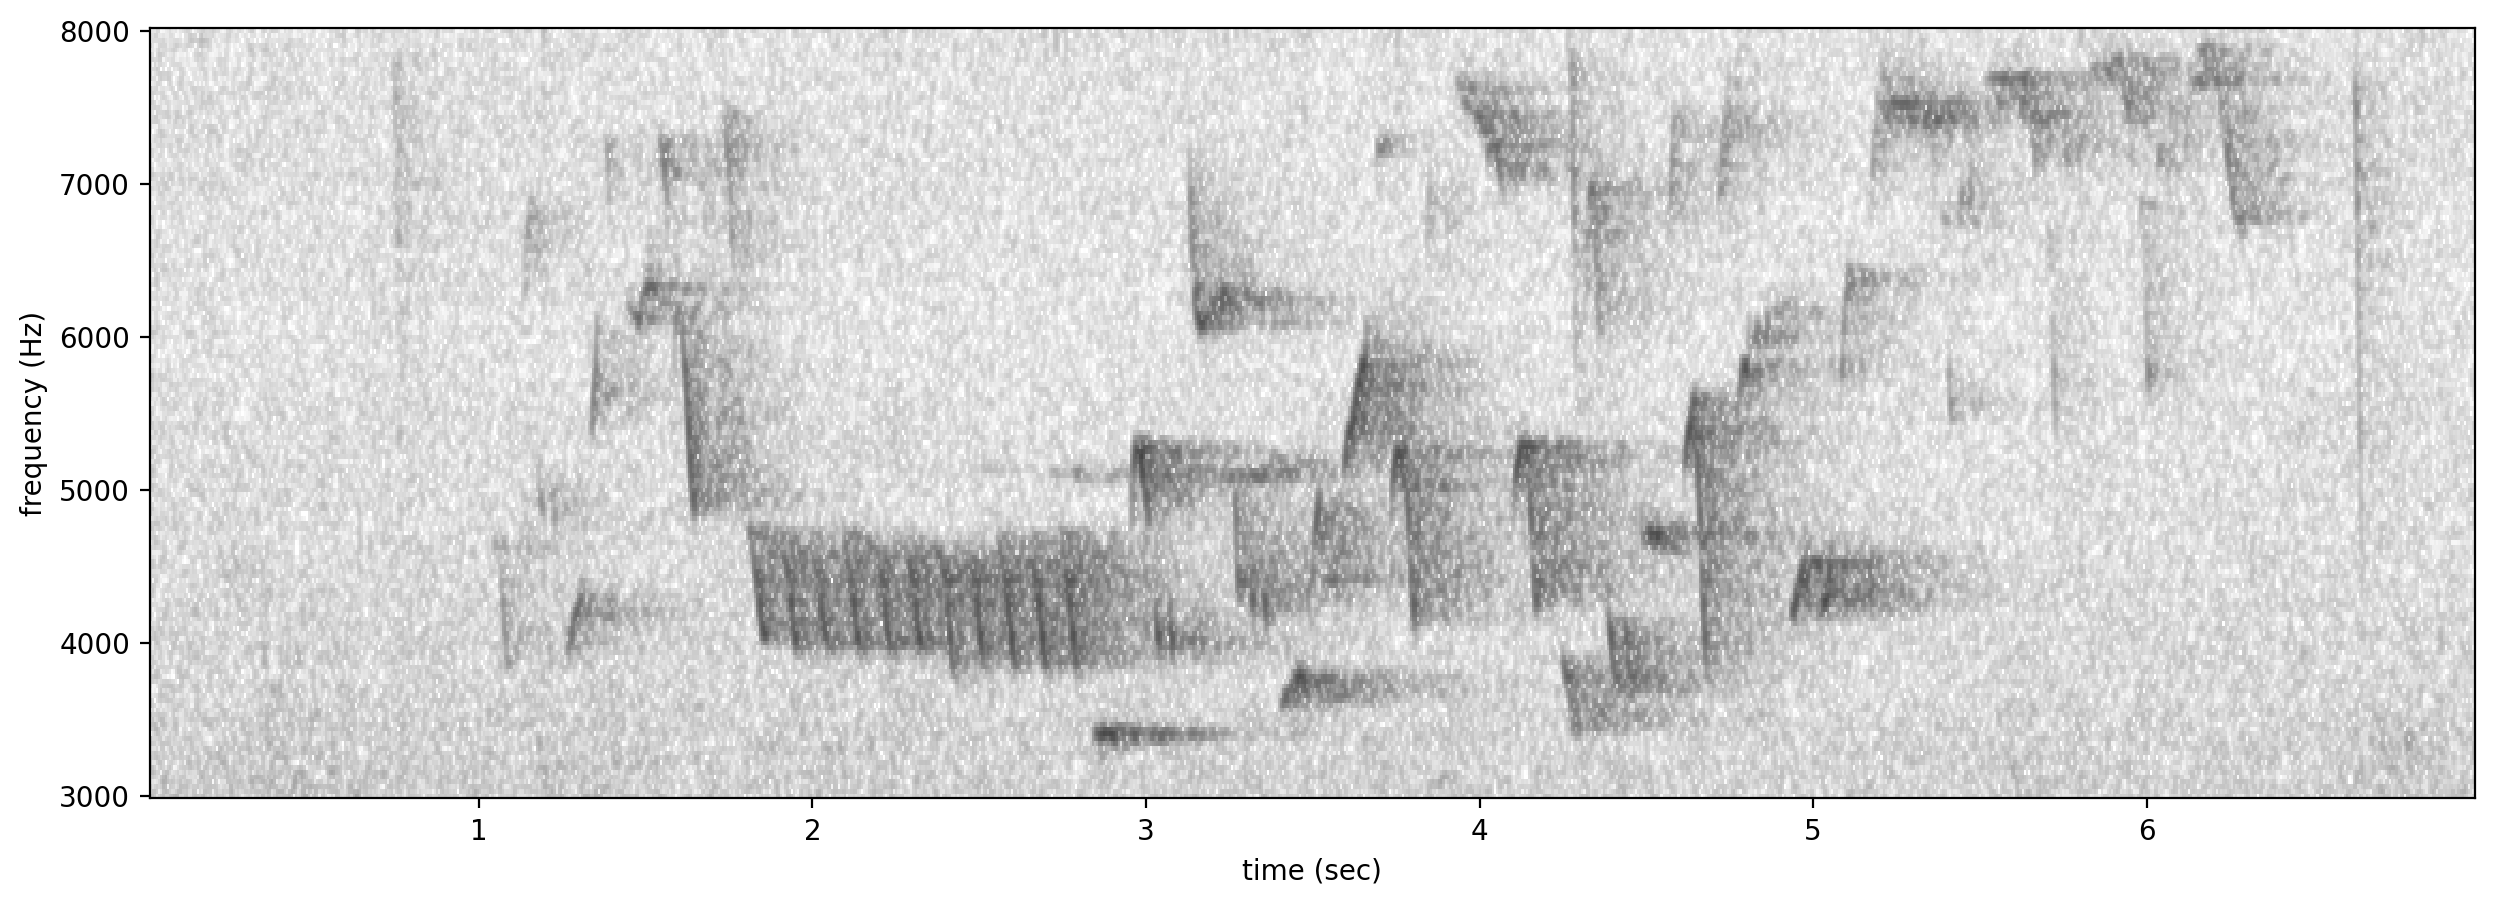

In [10]:
# Create spectrogram object from our previously loaded, trimmed audio object and view it. 
spec = Spectrogram.from_audio(trimmed_audio,window_samples=1024,overlap_fraction=0.8)

# bandpass and plot
spec.bandpass(3000,8000).plot()

## Saving audio files

Audio objects can be saved to various audio file formats such as WAV (uncompressed) and mp3 (compressed, lossy).

Changes to the Audio object's metadata are also retained in saved .WAV files.

In [16]:
# modify the temperature saved in the metadata
trimmed_audio.metadata['temperature_C']=-5 

# save the audio file
file_path = resource_path+'wiwr_7sec_call.WAV'
trimmed_audio.save(file_path)

# reload and check the metadata temperature
print(f"saved file's temperature field: {Audio.from_file(file_path).metadata['temperature_C']} C")

saved file's temperature field: -5 C


## Load region of audio file from specific date and time
Some audio files (including those recorded by AudioMoths) contain metadata indicating the start date and time of the audio recording. We can easily load a segment of audio starting at a specific date and time:

In [17]:
# specify the desired date and time of the Audio to load
from datetime import datetime
import pytz
local_timezone = pytz.timezone('US/Eastern')
desired_start = local_timezone.localize(datetime(2021, 6, 24, 6, 32,30))

Load 10 seconds of audio starting at 6:32:30 AM Eastern time on June 24, 2021

In [18]:
# load the audio at a specific time
segment = Audio.from_file(audio_path,start_timestamp=desired_start,duration=10)

# print the start time
print(f"segment start timestamp: {segment.metadata['recording_start_time'].astimezone(local_timezone).isoformat()}")

segment start timestamp: 2021-06-24T06:32:30-04:00


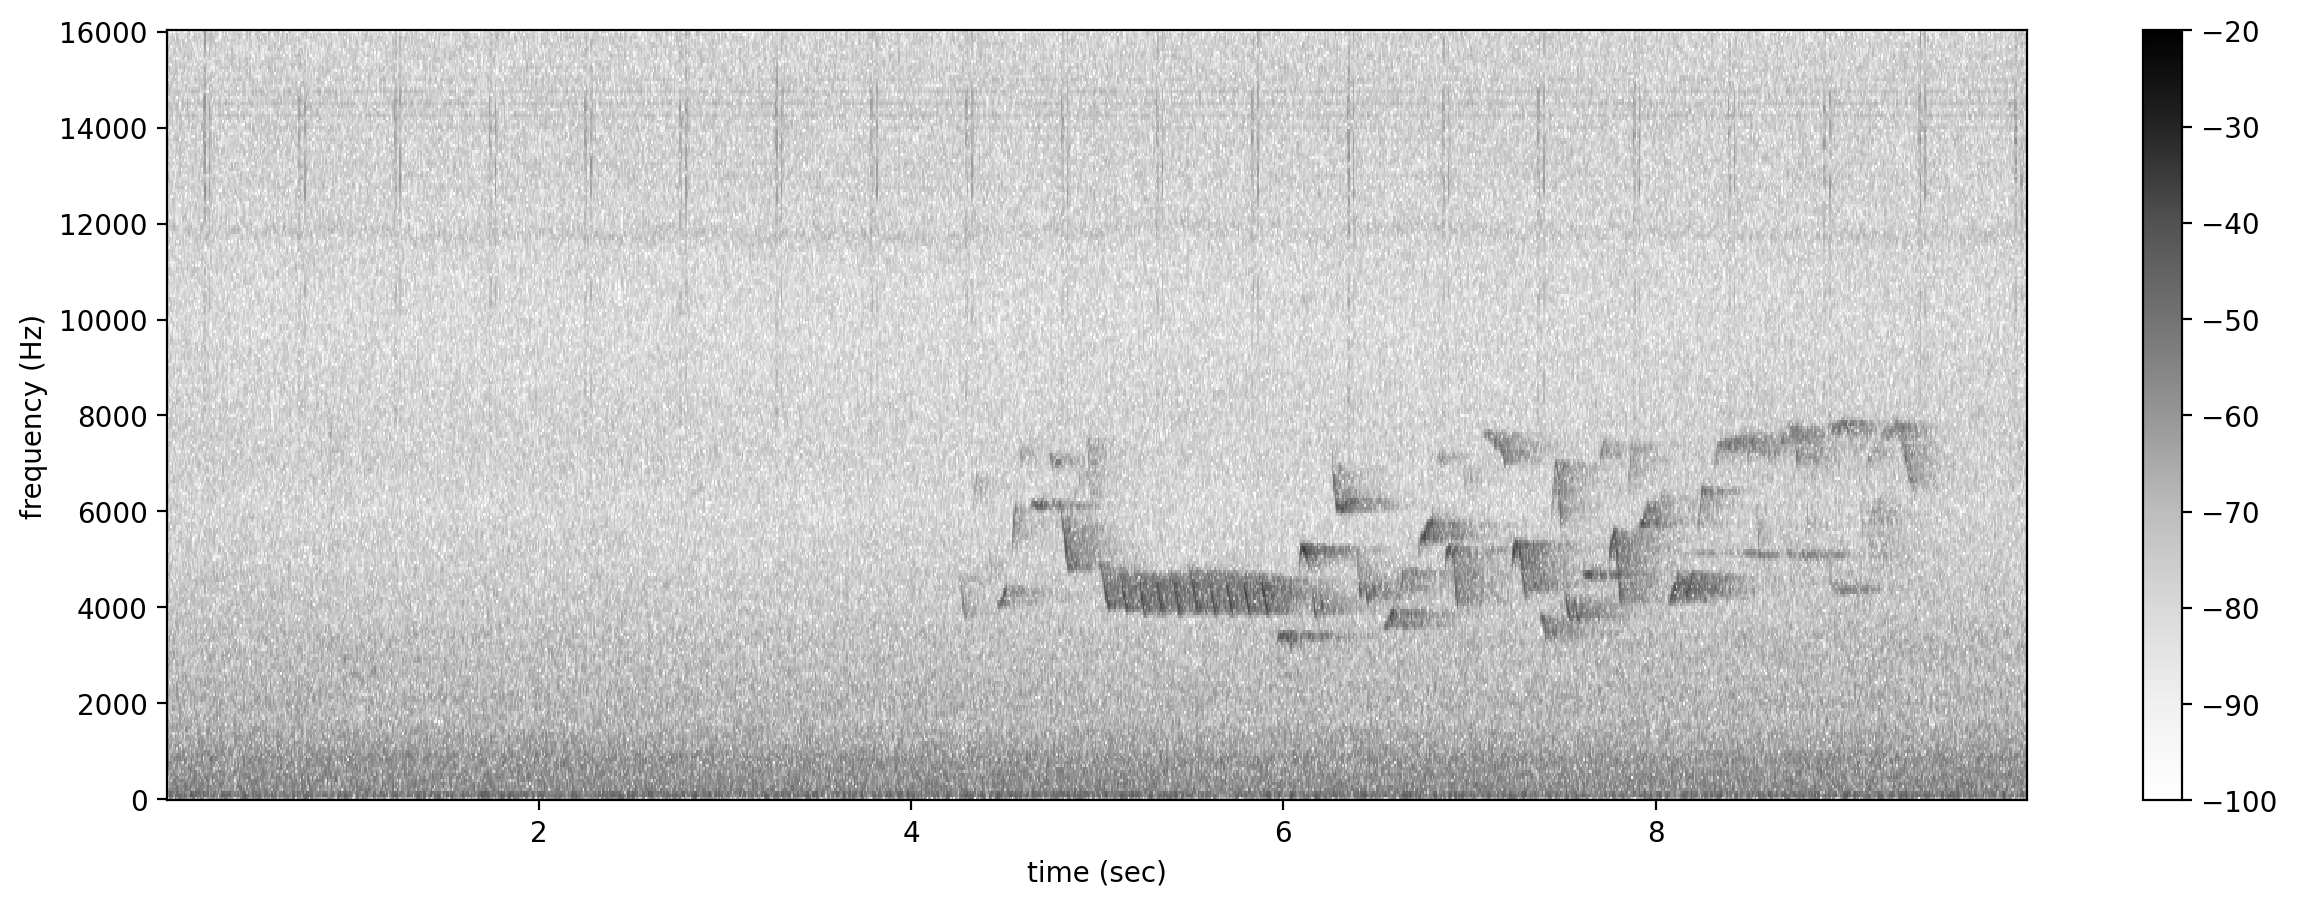

In [34]:
Spectrogram.from_audio(segment).plot(show_colorbar=True)

## Acoustic measurements

Using the Audio class, we measure dBFS (decibels full scale) for each 2-second segment of audio to get a sense of the overall signal level.

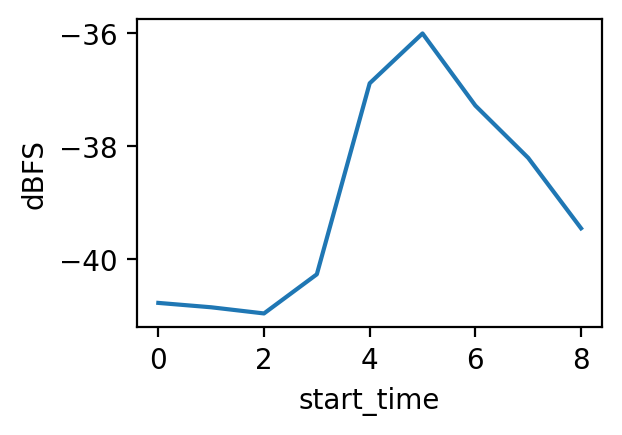

In [32]:
audio_segments, table = segment.split(clip_duration=2,clip_overlap=1)
table['dBFS']=[s.dBFS for s in audio_segments]
table.set_index('start_time')['dBFS'].plot(figsize=(3, 2))
_ = plt.ylabel('dBFS')

# Manipulating a northern parula call

Now that we know a few simple commands for manipulating audio and reading its metadata, we'll take a look at other sound properties that can be viewed and edited with OpenSoundscape. For the second part of this tutorial, we'll use the Northern Parula recording mentioned in the beginning.

First, we start by viewing the spectrogram

In [49]:
plt.rcParams['figure.figsize']=[5,2]

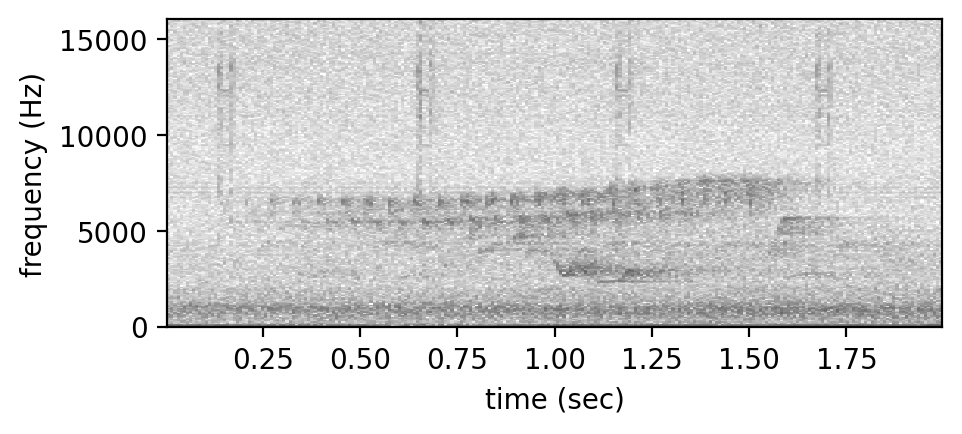

In [50]:
# create Audio from file path
file_path = resource_path+'parula_2sec_call.WAV'
audio = Audio.from_file(file_path)
Spectrogram.from_audio(audio).plot()

Let's make a series of adjustments to try to better isolate the Northern Parula call. 

First, we adjust the gain range in the displayed spectrogram from the default settings (-100 to -20 dB) to (-80 to -20), increasing contrast. 

Restricted decibel range: -80 to -30 dB


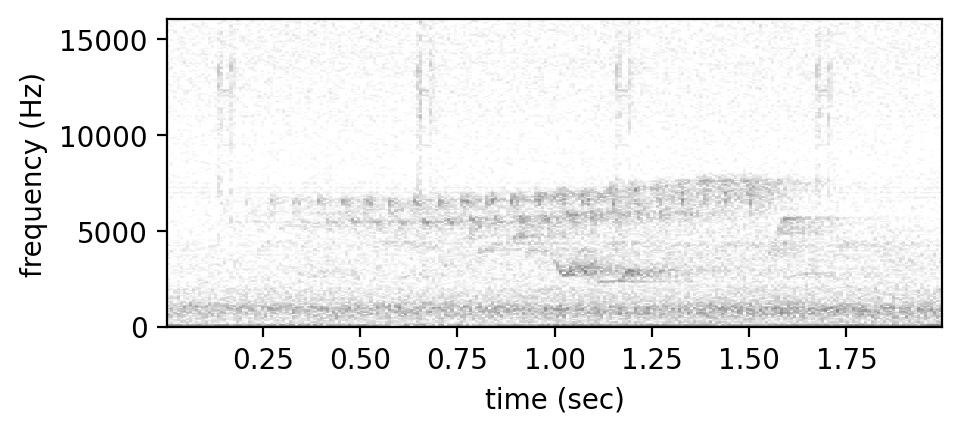

In [58]:
print('Restricted decibel range: -80 to -30 dB')
spec = Spectrogram.from_audio(audio, decibel_limits = (-80, -20))
spec.plot()

Next, let's apply a bandpass filter to the audio signal to remove frequencies outside of the range of the Northern Parula song:

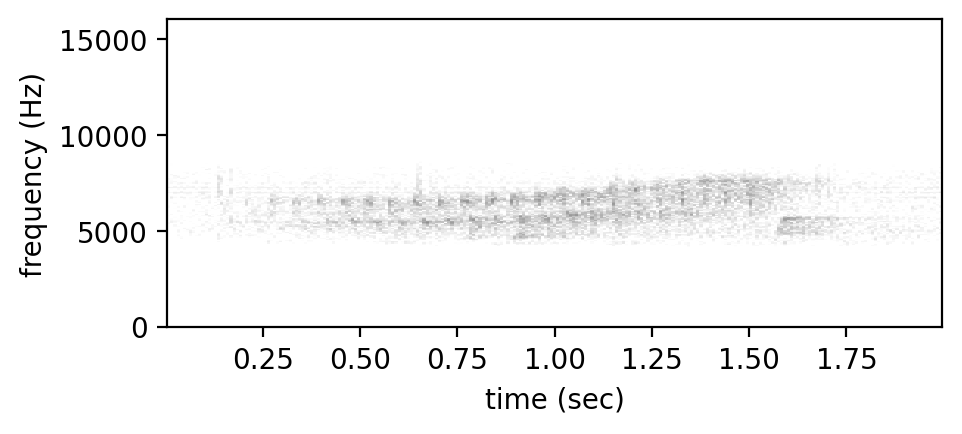

In [59]:
bandpassed_audio = audio.bandpass(low_f = 4500, high_f = 8500, order = 5)
spec = Spectrogram.from_audio(bandpassed_audio, decibel_limits = (-80, -20))
spec.plot()

Finally, let's normalize the Audio object to a peak of -10 dBFS to increase the volume of the recorded song

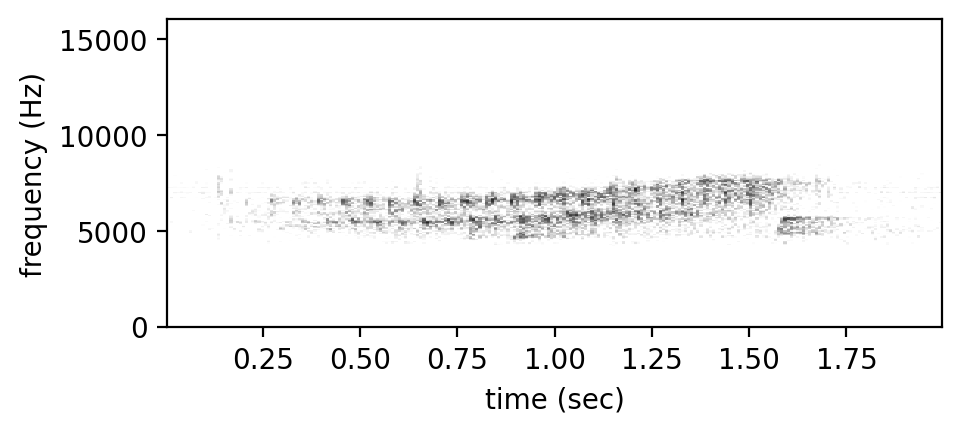

In [62]:
normalized_audio = bandpassed_audio.normalize(peak_dBFS=-10)
spec = Spectrogram.from_audio(normalized_audio, decibel_limits = (-50,-20))
spec.plot()

In [48]:
# Convert our spectrogram to an Image object and save it!
spec.to_image().save(resource_path+'example_1.png')

We've seen a few of the ways OpenSoundscape can be used to manipulate, visualize, and measure audio data. 

For full documentation of the [Audio]() and [Spectrogram]() classes, visit [opensoundscape.org](http://opensoundscape.org/en/latest/)